In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import cv2
import io
import requests
import os 
import copy

from PIL import Image
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
#parameters
image_size = 224
num_classes = 1000

In [18]:
print('STEP 3: CREATE MODEL CLASS (Pre-trained models)')

STEP 3: CREATE MODEL CLASS (Pre-trained models)


In [47]:
#Pre-trained AlexNet from model_zoo
pretrained_AlexNet = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',}

class AlexNet_Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, maxpool = False):
        super(AlexNet_Block, self).__init__()
        ###############
        # maxpooling layer argument의 상태에 따라 layer structure 구분
        if maxpool == True:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
                nn.ReLU(),
                nn.MaxPool2d(3, 2)
            )
            
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
                nn.ReLU()
            )
        ###############
        
    def forward(self, x):
        ###############
        out = self.conv(x)
        
        return out
        ###############

    
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        ###############
        # sequential로 묶음
        self.conv = nn.Sequential(
            AlexNet_Block(3, 64, 11, 4, 2, True),
            AlexNet_Block(64, 192, 5, 1, 2 ,True),
            AlexNet_Block(192, 384, 3, 1, 1),
            AlexNet_Block(384, 256, 3, 1, 1),
            AlexNet_Block(256, 256, 3, 1, 1, True)
        )        
        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
        ###############

    def forward(self, x):
        ###############
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        
        
        return out
        ###############

In [55]:
#Pre-trained VGGnet-16 from model_zoo
pretrained_vgg = {'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
                'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
                'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
                'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',}

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
 
class VGGnet(nn.Module):
    def __init__(self, features, num_classes=num_classes):
        super(VGGnet, self).__init__()
        ###############
        self.conv = features
    
        self.ReLU = nn.ReLU()
        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
        ###############
       
    def forward(self, x):
        ###############
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        out = self.fc(x)
        
        return out
        ###############
  
                
def make_layers(cfg, batch_norm=False):
    ###############
    layer = []
    in_ch = 3
    #list 내의 argument들을 config로 assign 해준다.
    for config in cfg:
        # config의 data type이 int일 경우 conlayer를 만들어 output = config를 해주고 layer를 append 이후 새로운 input으로 config를 할당해준다.
        # config의 data type이 int가 아닌 경우 어떤 형태인지 알아야하나 cfg내의 int형이 아닌 data type은 'M'밖에 존재하지 않으므로 아닌 경우 Maxpooling layer를 만들어 append 해준다.
        if type(config) is int:
            layer.append(nn.Conv2d(in_ch, config, kernel_size=3, stride=1, padding=1))
            layer.append(nn.ReLU())
            in_ch = config
            
        else: layer.append(nn.MaxPool2d(2,2))
            
    return nn.Sequential(*layer)
    ###############

In [56]:
print('STEP 4: INSTANTIATE MODEL CLASS')

##AlexNet
def alexnet(model, pretrained=False):
    ###############
    print("start AlexNet update!")
    pretrained_dict = model_zoo.load_url(pretrained_AlexNet['alexnet'])
    pretrained_key = list(pretrained_dict)
    #dictionary 정렬
    new_state_dict = OrderedDict()
    #model dictionary를 불러옴
    model_dict = model.state_dict()
    
    if pretrained== True:
        for i, (key, value) in enumerate(model_dict.items()):
            # Get only feature's weight from model zoo(pretrained weight)
            # model의 key 값이 conv(or fc).n.weight(or bias)이므로 해당 key가 발견되면 update
            if 'weight' or 'bias' in key:
                new_state_dict[key] = pretrained_dict[pretrained_key[i]]
                if new_state_dict[key] is pretrained_dict[pretrained_key[i]]:
                    print('go', key, 'update complete!')
            else:
                new_state_dict[key] = value
                print('bad', key, 'update failed!')
                
        model.load_state_dict(new_state_dict)
        print("\n\n")
    return model
    ###############

model_AlexNet = alexnet(AlexNet(), pretrained=True)

## VGG-16, no batch_norm
def vggnet(model, pretrained=False):
    ###############
    print("start AlexNet update!")
    pretrained_dict = model_zoo.load_url(pretrained_vgg['vgg16'])
    pretrained_key = list(pretrained_dict)
    
    new_state_dict = OrderedDict()
    
    model_dict = model.state_dict()
    
    if pretrained== True:
        for i, (key, value) in enumerate(model_dict.items()):
            # Get only feature's weight from model zoo(pretrained weight)
            # model의 key 값이 conv(or fc).n.weight(or bias)이므로 해당 key가 발견되면 update
            if 'weight' or 'bias' in key:
                new_state_dict[key] = pretrained_dict[pretrained_key[i]]
                if new_state_dict[key] is pretrained_dict[pretrained_key[i]]:
                    print('go', key, 'update complete!')
            else:
                new_state_dict[key] = value
                print('bad', key, 'update failed!')
                
        model.load_state_dict(new_state_dict)
    return model
    ###############

model_VGGnet = VGGnet(make_layers(cfg['D'], batch_norm=False))
model_VGGnet = vggnet(model_VGGnet, pretrained=True)


STEP 4: INSTANTIATE MODEL CLASS
start AlexNet update!
go conv.0.conv.0.weight update complete!
go conv.0.conv.0.bias update complete!
go conv.1.conv.0.weight update complete!
go conv.1.conv.0.bias update complete!
go conv.2.conv.0.weight update complete!
go conv.2.conv.0.bias update complete!
go conv.3.conv.0.weight update complete!
go conv.3.conv.0.bias update complete!
go conv.4.conv.0.weight update complete!
go conv.4.conv.0.bias update complete!
go fc.1.weight update complete!
go fc.1.bias update complete!
go fc.4.weight update complete!
go fc.4.bias update complete!
go fc.6.weight update complete!
go fc.6.bias update complete!



start AlexNet update!
go conv.0.weight update complete!
go conv.0.bias update complete!
go conv.2.weight update complete!
go conv.2.bias update complete!
go conv.5.weight update complete!
go conv.5.bias update complete!
go conv.7.weight update complete!
go conv.7.bias update complete!
go conv.10.weight update complete!
go conv.10.bias update complete!
go 

In [57]:
print("AlexNet's Summary:")
model_AlexNet.to(device)
summary(model_AlexNet, (3, 224, 224))


print("\nVGGnet's Summary:")
model_VGGnet.to(device)
summary(model_VGGnet, (3, 224, 224))

AlexNet's Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
     AlexNet_Block-4           [-1, 64, 27, 27]               0
            Conv2d-5          [-1, 192, 27, 27]         307,392
              ReLU-6          [-1, 192, 27, 27]               0
         MaxPool2d-7          [-1, 192, 13, 13]               0
     AlexNet_Block-8          [-1, 192, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         663,936
             ReLU-10          [-1, 384, 13, 13]               0
    AlexNet_Block-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 256, 13, 13]         884,992
             ReLU-13          [-1, 256, 13, 13]               0
    AlexNet_Block-14

In [58]:
#test images with ImageNet class number
test_list = (('./datasets/lab4/test_images/kingsnake.jpg', 56),
             ('./datasets/lab4/test_images/cat_dog.png', 243),
             ('./datasets/lab4/test_images/cat_dog.png',282),
             ('./datasets/lab4/test_images/pizza.jpg', 963))

#imagenet class
imagenet_class = {56: 'king snake',243: 'bull mastiff', 282: 'tiger cat', 963: 'pizza'}

In [59]:
class GradCAM():
    def __init__(self, model):
        ###############
        self.model = model
        self.model.cuda()
        self.model.eval()
        self.grad = None
        
        # gradient를 마지막 conv layer와 maxpooling layer사이에서 hook하기위해 나누어 주었다.
        self.conv = self.model.conv[:-1]
        self.maxpool = self.model.conv[-1]
        self.classifier = self.model.fc
        
        ###############
    
    # A backward hook function to save gradients(weights for visualizing)
    def save_gradient(self, grad): 
        ###############
        # gradient를 저장
        self.grad = grad
        
        ###############
    
    def forward_model(self,x):

        ###############
        # activation map을 만들기 위해 작성
        feature = self.conv(x)
        # activation map에대한 gradient를 hook
        self.h = feature.register_hook(self.save_gradient)
        
        x = self.maxpool(feature)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return feature, x
        ###############
    
    def gen_CAM(self, img, one_hot_target):
        ###############
        
        conv_feature, output = self.forward_model(img)
        # dimension = [batch, channel, h, w]이므로 batch의 dimension을 삭제
        activation = conv_feature.cpu().data[0, :]
        # activataio의 window size와 동일한 grad cam map 생성
        grad_cam = torch.ones(activation.shape[1:])
        
        self.model.zero_grad()
        output.backward(gradient = one_hot_target)
        grad = self.grad
        grad = F.adaptive_avg_pool2d(grad, 1)
        # batch size unsqueeze
        weights = grad.cpu().data[0]
        # k-th activation map과 gradient weight을 곱해서 더함       
        for i, weight in enumerate(weights):
            grad_cam += weight*activation[i]
        grad_cam = F.relu(grad_cam)
        # 자료형 tensor to numpy
        grad_cam = np.array(grad_cam)
        grad_cam = cv2.resize(grad_cam, (img.size(2),img.size(3)))
        grad_cam = (grad_cam-np.min(grad_cam))/(np.max(grad_cam) - np.min(grad_cam) + 1e-08) # Min/Max Normalization
        
        return grad_cam
        ###############

In [60]:
# image array to image tensor
def preprocess_image(img, resize_img=True):
   
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if resize_img:
        img = img.resize((224,224))
    img_arr = np.float32(img)
    img_arr = img_arr.transpose(2, 0, 1) 

    for c, _ in enumerate(img_arr):
        img_arr[c] /= 255
        img_arr[c] -= mean[c]
        img_arr[c] /= std[c]

    img_tensor = torch.from_numpy(img_arr).float()
    img_tensor = torch.unsqueeze(img_tensor,0)
    
    return img_tensor

#image tensor to image array
def reprocess_image(img):
    
    img = torch.squeeze(img,0)
    mean = [-0.485, -0.456, -0.406]
    std = [1/0.229, 1/0.224, 1/0.225]
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    for c in range(3):
        img_re[c] /= std[c]
        img_re[c] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    img_re = np.round(img_re * 255)

    img_re = np.uint8(img_re).transpose(1, 2, 0)
    
    return img_re

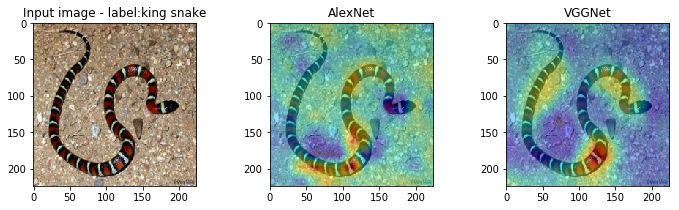

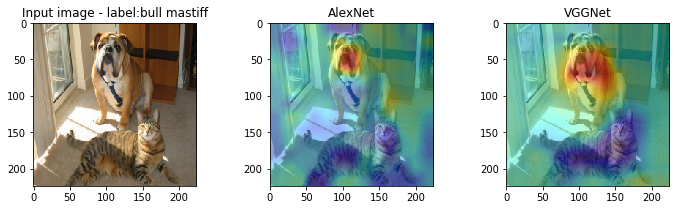

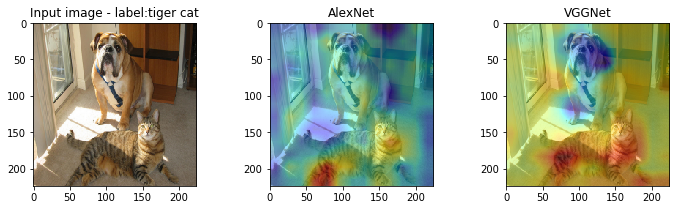

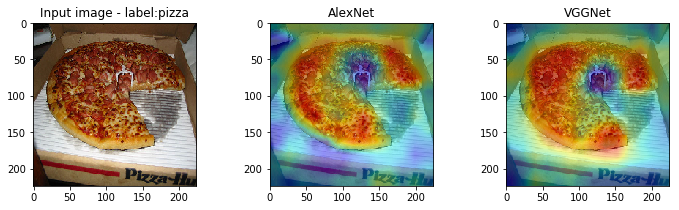

In [61]:
# Instantiation
gradcam_Alex = GradCAM(model_AlexNet)
gradcam_VGG = GradCAM(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.to(device)
    
    cam_img_VGGNet = gradcam_VGG.gen_CAM(img, one_hot_target)
    cam_img_AlexNet = gradcam_Alex.gen_CAM(img, one_hot_target)
    
    
    
    fig = plt.figure(figsize=(12, 3))
    fig.add_subplot(1,3,1).set_title('Input image - label:{}'.format(imagenet_class[target_class]))
    plt.imshow(reprocess_image(img))
    fig.add_subplot(1,3,2).set_title('AlexNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_AlexNet, alpha=0.4, cmap='jet')
    fig.add_subplot(1,3,3).set_title('VGGNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_VGGNet, alpha=0.4, cmap='jet')
    plt.show()

### Discussion
> Model
>>- AlexNet : AlexNet은 입력해야하는 argument들이 단순하고 직관적이여서 구현하는 것에 있어 큰 어려움이 없었다. summary결과가 동일한 것을 확인 가능하다.

>>- VggNet : Vgg16Net은 cfg를 입력받아야하는데 list object에 대한 이해가 조금 부족하여 list내부의 data를 처리하는 부분을 공부하고 코드를 작성하였다. summary결과가 동일한 것을 확인 가능하다.

>>- pretrained model update : 기존에 올라온 CAM Model의 코드를 그대로 이용하려 했으나 AlexNet에서는 bias가 업데이트가 안되고 VggNet에서는 dictionary의 key value가 다르다는 것을 확인하고 두 코드 모두 key에 weight와 bias값이 존재할 경우 update가 되게끔 코딩하였다.  

> Grad-CAM 
>>- Feature extract : conv_layer 이후 feature 많을 뽑으면 되었기에 model을 design할 때 sequential로 fc layer와 conv_layer를 분리하였다. 다만, conv_layer 마지막의 max_pooling layer를 제외하는 부분을 신경쓰고 return 값에 output과 feature를 반환하였다.

>>- Gradient extract : 처음에는 save_gradient를 list로 받아서 append 하려 했으나 이유는 모르겠으나 첫 번째 사진 생성이후 gradient의 dimension이 초기화 되지 않는 문제가 생겼다. gradient값이 한 layer에 대하여만 필요 했기에 이후 None type으로 assign해주고 값을 입력하는 방식으로 바꾼 이후로는 잘 되었다. conv_layer 이후 register_hook으로 값을 입력받았다. 

>>- data object type synchronization : 마지막으로 generate CAM에서 data type을 numpy로 통일하고 연산을 진행하려했으나 GAP(F.Adaptive average poolin)을 적용하는 부분까지는 Tensor 형 자료로 연산을 하고 그 이후 numpy 형식으로 전환하였다. 

> Result Analysis :
>> - 전반적으로 OBJECT가 하나인 경우에는 비슷한 성능을 보인다. 그러나 labeled object가 두 개가 포함된 사진에서는 VggNet이 더욱 높은 성능을 보이는 것을 알 수 있다.
>> - fc layer에 linear 뒤에 ReLU() activation의 존재 여부에 grad cam의 성능 차이가 존재하였다. target에 대하여 활성화되는 정도 또한 ReLU적용시 높아졌으나 backgroun에 대하여도 활성화가 조금 일어났다. 그러나 target activation을 더욱 쉽게 확인할 수 있는 것이 ReLU를 적용한 것이어서 ReLU를 적용하였다.

### Guided Backpropagation Visualization

In [15]:
class GBackprop():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        # First layer of network where we register hook to
        self.first_layer = self.model.features[0]
        self.gradient = None 
        # hook functions to first layer and relus
        self.hook_conv()
        self.hook_relu()
            
    
    #register hook to module(Conv2d)
    def hook_conv(self):
        #To save gradient from top (our visualization)
        def save_gradient(module, grad_input, grad_output):
            self.gradient = grad_input[0]
        
        self.first_layer.register_backward_hook(save_gradient)
        
    #register hook to module(ReLU)
    def hook_relu(self):
        # To pass only positive gradients at ReLU
        def relu_gradient(module, grad_input, grad_output):
            if isinstance(module, nn.ReLU):
                return (torch.clamp(grad_input[0], min =0.0),)
        
        for module in self.model.features.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_gradient)
    
    def forward_model(self,x):
        x = self.model.features(x)
        x = x.view(x.size(0),-1)
        x = self.model.classifier(x)
        
        return x
    
    def gen_mask(self, img, one_hot_target):
        
        output = self.forward_model(img)
        
        self.model.zero_grad()
        
        # for gradient computing with our specified class
        output.backward(gradient = one_hot_target)
        # our visualization mask (to array)
        gradients = self.gradient.cpu().data.numpy()[0]
        #gradients mask 
        gradients_mask = gradients.transpose(1,2,0)
        gradients_mask = (gradients_mask-np.min(gradients_mask))/(np.max(gradients_mask) - np.min(gradients_mask) + 1e-08)
        
        return gradients, gradients_mask 

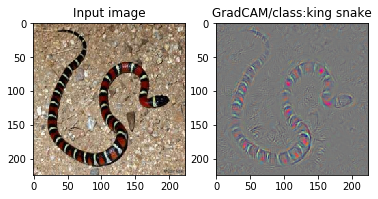

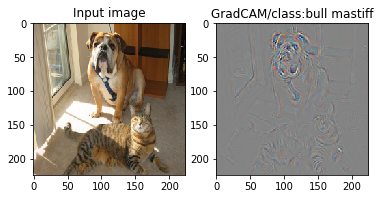

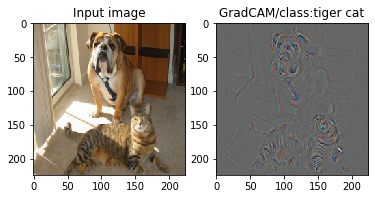

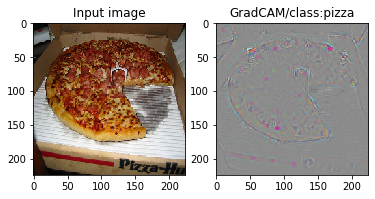

In [16]:
guided_backprop = GBackprop(model_AlexNet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)
    
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(mask)
    

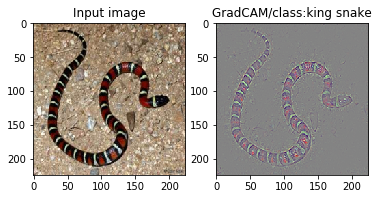

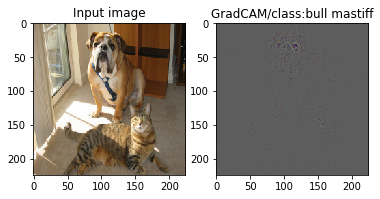

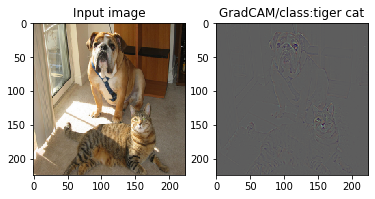

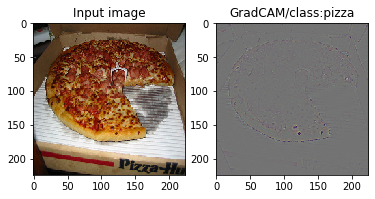

In [17]:
guided_backprop = GBackprop(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    gradient_numpy,mask = guided_backprop.gen_mask(img, one_hot_target)
    
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(mask)
    

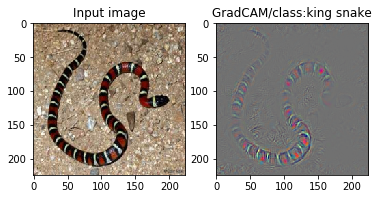

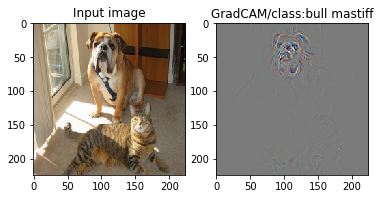

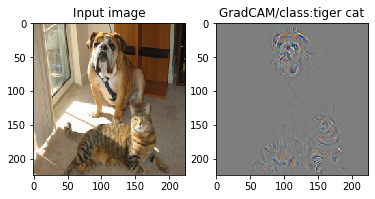

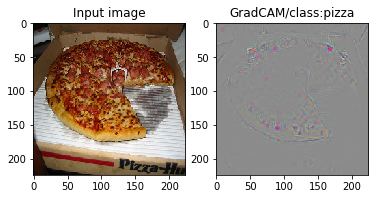

In [18]:
gradcam = GradCAM(model_AlexNet)
guided_backprop = GBackprop(model_AlexNet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    cam_img = gradcam.gen_CAM(img, one_hot_target)    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    guided_gradcam = np.multiply(cam_img, gradient_numpy).transpose(1,2,0)
    guided_gradcam = (guided_gradcam-np.min(guided_gradcam))/(np.max(guided_gradcam) - np.min(guided_gradcam) + 1e-08)
    
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(guided_gradcam)
    

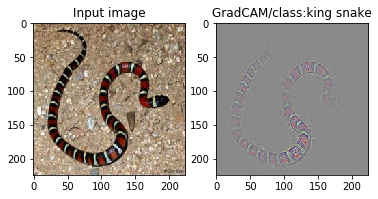

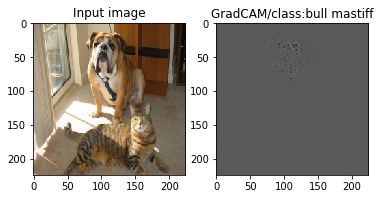

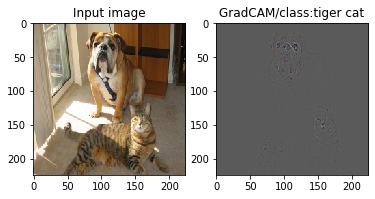

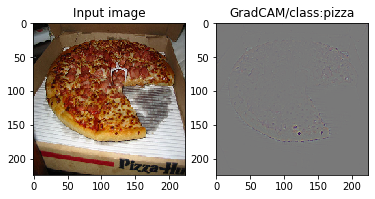

In [19]:
gradcam = GradCAM(model_VGGnet)
guided_backprop = GBackprop(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)

    cam_img = gradcam.gen_CAM(img, one_hot_target)    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    guided_gradcam = np.multiply(cam_img, gradient_numpy).transpose(1,2,0)
    guided_gradcam = (guided_gradcam-np.min(guided_gradcam))/(np.max(guided_gradcam) - np.min(guided_gradcam) + 1e-08)
    
  
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(guided_gradcam)
    